<a href="https://colab.research.google.com/github/AliceRai/Portfolio/blob/main/Progetto_filtro_per_fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import nltk
nltk.download('stopwords')  #scarichiamo le stopwords
from nltk.corpus import stopwords  #importiamo le stopwords
stop_words = stopwords.words('english') #prediamo solo le stopwords in inglese

from collections import Counter

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#leggiamo il testo che contiene le fake news
data_fake=pd.read_csv("Fake.csv",  encoding='utf-8')
data_fake.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
#leggiamo il testo che contiene le true news
data_true=pd.read_csv("True.csv",  encoding='utf-8')
data_true.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
#associamo un'etichetta ai due dataset
data_fake['label']=0
data_true['label']=1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Le fake news sono più frequenti in una determinata categoria?

In [ ]:
data_fake["subject"].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
subject,
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


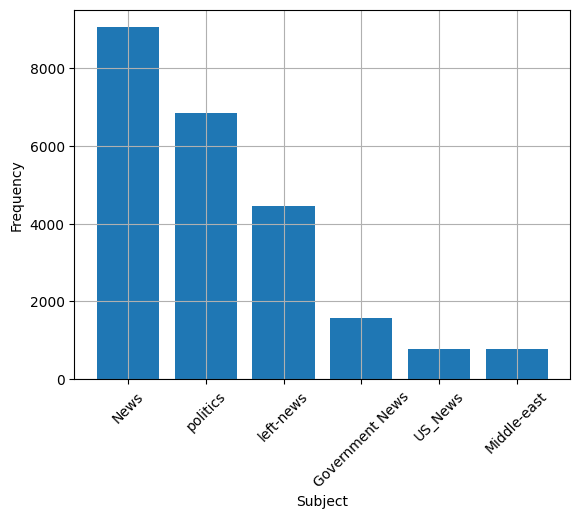

In [ ]:
plt.bar(data_fake["subject"].value_counts().index, data_fake["subject"].value_counts())
plt.xlabel('Subject')
plt.xticks(rotation=45)
plt.grid()
plt.ylabel('Frequency')
plt.show()

Il grafico e il conteggio dei valori ci mostrano che le categoria "news" e "politics" sono le più soggette a fake news. Abbiamo infatti 9050 notizie fake con categoria "news" e 6841 con categoria "politics".

###I titoli delle fake news presentano dei pattern ricorrenti?

In [ ]:
#estraiamo i titoli dal file delle fake new e analizziamoli
data_fake_title=data_fake["title"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#creiamo due funzioni di pulizia del testo

#trasformiamo le frasi in liste di parole pulite.
def sent_to_words(items): #la funzione prende in input la lista di documenti

    for item in items:
        yield(simple_preprocess(item, deacc=True))

#Rrimuoviamo le stopwords
def remove_stopwords(texts): #prende in input la lista creata con la funzione sent_to_words
    return [[word for word in words if word not in stop_words and len(word) >=5] for words in texts]

#chiamiamo la prima funzione che riceve in input il nostro documento
data_fake_title_words = list(sent_to_words(data_fake_title))
#poi chiamiamo la seconda funzione che riceve in input la lista di liste data_fake_title_words
data_fake_title_cleaned = remove_stopwords(data_fake_title_words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###I titoli delle fake news presentano dei pattern ricorrenti?

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


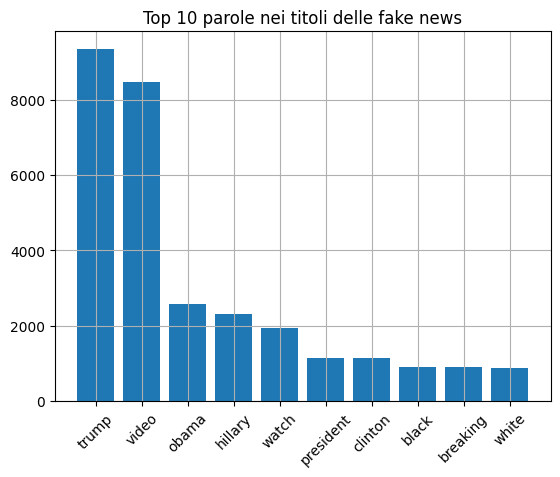

In [ ]:
#proviamo a vedere quali sono le 10 parole più utilizzate nei titoli di fake news

# Uniamo tutte le liste di parole in un'unica lista
all_title = [word for title in data_fake_title_cleaned for word in title]

# Contiamo le parole
word_counts = Counter(all_title)

# Ottieniamo le 10 parole più comuni
common_words = word_counts.most_common(10)

# Visualizziamo le parole più comuni
words = [word for word, count in common_words]
counts = [count for word, count in common_words]
plt.bar(words, counts)
plt.title('Top 10 parole nei titoli delle fake news')
plt.xticks(rotation=45)
plt.grid()
plt.show()



Il grafico mostra come le parole più ricorrenti nei titoli delle fake news siano "Trump" e "video"

###Esistono argomenti che sono più soggetti alle fake news?

In [ ]:
#Procediamo con un'analisti di topic modeling per trovare gli argomenti più ricorrenti nelle fake news

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#creiamo una variabile che unisca titoli e testo delle fake news
data_fake_doc=data_fake["title"]+" "+data_fake["text"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#puliamo la variabile con le funzioni create
data_fake_doc_words = list(sent_to_words(data_fake_doc))
data_fake_complete_words = remove_stopwords(data_fake_doc_words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Creiamo il dizionario
id2word = corpora.Dictionary(data_fake_complete_words) #passiamo la lista di documenti che contengono le singole parole

# Vettorizziamo e sostiuiamo le parole con vettori numerici
corpus = [id2word.doc2bow(text) for text in data_fake_complete_words]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
num_topics = 10

# Costruiamo il modello LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, #passiamo il corpus
                                       id2word=id2word,#il dizionario
                                       num_topics=num_topics,
                                       passes = 3) #indichiamo il numero di passi da eseguire

doc_lda = lda_model[corpus] #inseriamo nella variabili doc_lda i documenti divisi per topic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#stampiamo i topics
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.039*"obama" + 0.028*"president" + 0.021*"trump" + 0.010*"party" + 0.010*"house" + 0.010*"republican" + 0.010*"would" + 0.009*"republicans" + 0.007*"democrats" + 0.006*"senate"')
(1, '0.008*"people" + 0.006*"america" + 0.006*"would" + 0.006*"government" + 0.006*"american" + 0.005*"states" + 0.005*"million" + 0.005*"state" + 0.004*"country" + 0.004*"united"')
(2, '0.041*"trump" + 0.016*"people" + 0.014*"president" + 0.013*"video" + 0.007*"donald" + 0.007*"going" + 0.007*"watch" + 0.006*"think" + 0.006*"would" + 0.006*"country"')
(3, '0.011*"school" + 0.010*"climate" + 0.008*"change" + 0.008*"children" + 0.006*"national" + 0.006*"world" + 0.005*"hollywood" + 0.005*"anthem" + 0.005*"germany" + 0.005*"global"')
(4, '0.057*"clinton" + 0.043*"hillary" + 0.014*"state" + 0.012*"election" + 0.012*"campaign" + 0.008*"democratic" + 0.007*"email" + 0.006*"presidential" + 0.006*"party" + 0.006*"voters"')
(5, '0.015*"police" + 0.011*"black" + 0.007*"people" + 0.007*"video" + 0.006*"white" + 0.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


L'analisi ci mostra 10 topics presenti nel dataset delle fakenews e vediamo come la parola "Trump" sia sempre una delle più presenti. In particolare nel topic n.6 è associata alle parole donald-twitter-media-video-campaing-hillary che ci fanno pensare a fakenews nell'ambito di notizie pubblicate sui social in merito alla campagna elettorale di Trump. Il topic n.4 invece potrebbe afferire maggiormente a notizie della campagna elettorale di Clinton.

In [ ]:
#proviamo a visualizzarli graficamente con PLYDAVIS
!pip install pyldavis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Prepariamo i dati per la visualizzazione
lda_display = gensimvis.prepare(lda_model, corpus, id2word)

# Mostriamo la visualizzazione
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  token_table['Freq'] = token_table['Freq'].round()
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

La visualizzazione grafica conferma che la parola "Trump", seguita da "President" sono le parole più ricorrenti nelle notizie false. il topic 1 e il topic 2 sembrano invece essere i più comuni tra tutte le fake news.

###Addestriamo un modello per riconoscere le fake news


In [ ]:
#Concateniamo il dataset con fake news con il dataset con true news
data_complete=pd.concat([data_fake,data_true], axis=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(data_complete) #verifichiamo che l'unione sia riuscita

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


44898

In [ ]:
#puliamo il dataset con le funzioni sent_to_words e remove_stopwords
data_complete_words = list(sent_to_words(data_complete["title"]+" "+data_complete["text"]))
data_complete_cleaned = remove_stopwords(data_complete_words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Convertiamo le liste di parole in frasi
cleaned_sentences = [' '.join(words) for words in data_complete_cleaned]

# Aggiungi il testo pulito al DataFrame
data_complete['cleaned_text'] = cleaned_sentences

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
X = data_complete['cleaned_text']  # Testo pulito
y = data_complete['label']  # Target

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Dividiamo il dataset in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Converti il testo in una rappresentazione numerica (TF-IDF)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


REGRESSIONE LOGISTICA

In [ ]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LogisticRegression()

In [ ]:
y_pred = logistic_regression_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9828507795100223
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      4733
           1       0.98      0.98      0.98      4247

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def evaluate_model(model,dataset):  #prende in input il modello e il dataset
    X,y= dataset  #tupla con feature e target
    y_pred=model.predict(X)

    print(f"MSE: {mean_squared_error(y,y_pred):.3f}")
    print(f"R2: {r2_score(y, y_pred):.3f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#valutiamo il modello sul set di addestramento
evaluate_model(logistic_regression_model, (X_train_tfidf, y_train))

MSE: 0.011
R2: 0.957


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#valutiamo il modello sul set di test
evaluate_model(logistic_regression_model, (X_test_tfidf, y_test))

MSE: 0.017
R2: 0.931


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dopo vari test il modello di Regressione Logistica sembra essere il modello più performante, con una maggiore accuratezza e migliori metriche di valutazione complessive.
Per completezza si riporta alla fine del codice il modello Naive Bayes che è stato testato e confrontato con il modello di Regressione Logistica.

###Esportazione del modello in formato pkl per l'implementazione in Chrome.

In [ ]:
import pickle
# Salviamo il modello
with open('filter_fake_news_model.pkl', 'wb') as file:
    pickle.dump(logistic_regression_model, file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MODELLO NAIVE BAYES

In [ ]:
naive_bayes_model = MultinomialNB() #inizializziamo il modello
naive_bayes_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MultinomialNB()

In [ ]:
naive_bayes_model.score(X_test_tfidf, y_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9291759465478842

In [ ]:
y_pred = naive_bayes_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy: 0.9291759465478842
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      4733
           1       0.93      0.92      0.92      4247

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



In [ ]:
evaluate_model(naive_bayes_model, (X_train_tfidf, y_train))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MSE: 0.060
R2: 0.758


In [ ]:
evaluate_model(naive_bayes_model, (X_test_tfidf, y_test))

MSE: 0.071
R2: 0.716


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
